In [1]:
import os
import pandas as pd
import  datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split

from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
##https://stackoverflow.com/questions/59112197/importerror-cannot-import-name-evaluate-from-surprise-import-evaluate
from scipy.sparse.linalg import svds

from bokeh.plotting import figure, output_file, show
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.palettes import Spectral11, colorblind, Inferno, BuGn, brewer
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource,LinearColorMapper,BasicTicker, PrintfTickFormatter, ColorBar
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)


from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

## Data preprocessing

1. Load original CSV files.
2. Split title and year into separate columns. Convert year to datetime.
3. Categorize genres properly: split strings into boolean columns per genre.
Modify the rating timestamp: from universal seconds to datetime year.
Check for NaN values. Clean (delete rows) if % of NaN values is small.

In [2]:
## https://grouplens.org/datasets/movielens/20m/
data_path = '/Users/yangx/Downloads/ml-20m/'
movies_filename = 'movies.csv'
ratings_filename = 'ratings2.csv'
tags_filename='tags.csv'
df_tags = pd.read_csv(os.path.join(data_path, tags_filename))
df_movies = pd.read_csv(os.path.join(data_path, movies_filename),usecols=['movieId', 'title','genres'], dtype={'movieId': 'int32', 'title': 'str'})
df_ratings = pd.read_csv(os.path.join(data_path, ratings_filename), usecols=['userId', 'movieId', 'rating','timestamp'], 
                         dtype={'userId':'int32', 'movieId':'int32', 'rating':'float32'}
#                          ,parse_dates=['timestamp'],date_parser = pd.datetools.to_datetime
                        )

In [3]:
# add year column to the ratings
df_ratings['rating_year']=pd.to_datetime(df_ratings.timestamp)
df_ratings['rating_month']=df_ratings.rating_year.dt.month
df_ratings['rating_year']=df_ratings.rating_year.dt.year


# df_movies2=df_movies.copy()
# df_movies2.genres = df_movies2.genres.str.split('|')
# df_movies2 = explode(df_movies2, ['genres'])
# df_movies2.head()
#Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
df_movies['year']=df_movies.title.str.extract("\((\d{4})\)", expand = True)
df_movies['year'] = pd.to_datetime(df_movies.year, format='%Y')
# extract year digits
df_movies.year=df_movies.year.dt.year 
# As there are some NaN years, resulting type will be float (decimals)
#edit title
df_movies['title2']=df_movies.title.str[:-7]
df_movies.head()

,movieId,title,genres,year,title2
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,Toy Story
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0,Jumanji
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0,Grumpier Old Men
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995.0,Waiting to Exhale
4,5,Father of the Bride Part II (1995),Comedy,1995.0,Father of the Bride Part II


In [4]:
genres_unique = pd.DataFrame(df_movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre'])
df_movies = df_movies.join(df_movies.genres.str.get_dummies().astype(bool))
df_movies.drop('genres', inplace=True, axis=1)
df_movies.head()

,movieId,title,year,title2,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995.0,Toy Story,False,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji (1995),1995.0,Jumanji,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men (1995),1995.0,Grumpier Old Men,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale (1995),1995.0,Waiting to Exhale,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False
4,5,Father of the Bride Part II (1995),1995.0,Father of the Bride Part II,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


### Train test split

In [ ]:
# ratings_train_df, ratings_test_df = train_test_split(df_ratings,
#                                    stratify=df_ratings['userId'], 
#                                    test_size=0.20,
#                                    random_state=42)
# ratings_train_df.shape, ratings_test_df.shape

In [5]:
train1=df_ratings.loc[(df_ratings.rating_year==2000)| (df_ratings.rating_year==2001)]
print('train 2000 ~ 2001',train1.shape)

test1_12mo=df_ratings.loc[(df_ratings.rating_year==2002)]
test1_12mo_known=test1_12mo[test1_12mo['userId'].isin(train1['userId'].unique())]
train1_known=train1[train1['userId'].isin(test1_12mo_known['userId'].unique())]
print('test 2002 all',test1_12mo.shape)
print('test 2002 known',test1_12mo_known.shape)

test1_6mo=df_ratings.loc[(df_ratings.rating_year==2002)&(df_ratings.rating_month < 7)]
test1_6mo_known=test1_6mo[test1_6mo['userId'].isin(train1['userId'])]
print('test 2002 june all',test1_6mo.shape)
print('test 2002 june known',test1_6mo_known.shape)

train 2000 ~ 2001 (3139784, 6)
test 2002 all (869719, 6)
test 2002 known (213023, 6)
test 2002 june all (459225, 6)
test 2002 june known (124220, 6)


In [6]:
num_users = len(train1.userId.unique())
num_items = len(train1.movieId.unique())
print('There are {} unique users and {} unique movies in this training data set during 2000 ~ 2001'.format(num_users, num_items))

There are 22205 unique users and 4880 unique movies in this training data set during 2000 ~ 2001


### get the known user in both test and train set

In [7]:
known_users=list(test1_12mo_known.userId.unique())
test_seen_dict={}
    
for key in known_users:
    test_seen_dict[key]=test1_12mo_known.loc[test1_12mo_known.userId ==key,'movieId'].tolist()
test_seen_df=pd.DataFrame(test_seen_dict.items(), columns=['userId', 'movieId'])

In [8]:
train_known=train1[train1.userId.isin(known_users)]
train_known=train_known[['userId','movieId']]

train_users=list(train1.userId.unique())
train_seen_dict={}
    
for key in train_users:
    train_seen_dict[key]=train1.loc[train1.userId ==key,'movieId'].tolist()
train_seen_df=pd.DataFrame(train_seen_dict.items(), columns=['userId', 'movieIds'])

In [10]:
len(train_known),len(train_seen_df)

(827097, 22205)

### Evaluation

In [11]:
def evaluation(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    mini = min(len(list1),len(list2)) 
    return float(intersection) / mini
 

## CF KNN User-item based
1. cosine
2. pereason


In [12]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


In [13]:
import collections
import heapq 

#get top k frequent items from a list
def topKFrequent(nums, k):
    """
    :type nums: List[int]
    :type k: int
    :return type: List[int]
    """
    counter=collections.Counter(nums)
    return heapq.nlargest(k, counter, key=lambda x: counter[x])

#### Create User-MovieId table

In [14]:
user_train1=pd.pivot_table(train1, index='movieId', columns='userId', values='rating').T
user_train1=user_train1.fillna(0)
user_train1.shape

(22205, 4880)

### KNN with Cosine Similarity
https://en.wikipedia.org/wiki/Cosine_similarity

- Pros
- cons

In [15]:
user_train_matrix = csr_matrix(user_train1.values) # handle sparse matrice before input into KNN

# fit model
model_knn = NearestNeighbors(metric = 'cosine', algorithm= 'brute')
model_knn.fit(user_train_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [16]:
# Get top k recommended movies for each user
# it retuns a dictionary with key as user id and values as a list of movie id
def recomm_kmovies_cosine(df_train, model,n,topk):
    df_train_copy=df_train.copy()
    df_train_copy.reset_index(inplace=True)
    recomm_dict={}
    for i in range(df_train.shape[0]):
        distances, indices = model.kneighbors(df_train.iloc[i,:].values.reshape(1, -1), n_neighbors = n+1)
        uid=df_train_copy.iloc[i, :]['userId']
        l=[]
        for k in indices[0]:
            neirbor_uid=df_train_copy.iloc[k, :]['userId']
            m=train_seen_df.loc[train_seen_df.userId==neirbor_uid,'movieIds'].values[0]
            l.append(m)
        unnested= [k for i in l for k in i]
#         print(len(unnested),' ',i,' ',k)
        
        if topk > len(unnested):
            mvote = topKFrequent(unnested, topk)
        else:
            mvote = list(set(unnested))
        recomm_dict[uid]=mvote
    return recomm_dict

In [18]:
# make recommendation

cosine_recomm_dict=recomm_kmovies_cosine(user_train1,model_knn,5, 50)

In [19]:
# Get the evaluation score
test_seen_df['cosine_user_recomm']=test_seen_df['userId'].map(cosine_recomm_dict)
test_seen_df['cosine_eval']=test_seen_df.apply(lambda row: evaluation(row.movieId, row.cosine_user_recomm), axis=1)
test_seen_df.cosine_eval.mean()

0.3402988236440835

### hyperparameter tuning

In [20]:
## hyperparameter tuning
nb = [5,10,15,20]
topk = [25, 50, 75]
cos_list=[]
for i in nb:
    for k in topk:
        cosine_recomm_dict=recomm_kmovies_cosine(user_train1,model_knn,i, k)
        test_seen_df['cosine_user_recomm']=test_seen_df['userId'].map(cosine_recomm_dict)
        test_seen_df['cosine_eval']=test_seen_df.apply(lambda row: evaluation(row.movieId, row.cosine_user_recomm), axis=1)
        score = test_seen_df.cosine_eval.mean()
        l = [i, k, score]
        cos_list.append(l)
        

In [21]:
cos_list

[[5, 25, 0.3402988236440835],
 [5, 50, 0.3402988236440835],
 [5, 75, 0.3402988236440835],
 [10, 25, 0.4342589006234369],
 [10, 50, 0.4342589006234369],
 [10, 75, 0.4342589006234369],
 [15, 25, 0.48763248777284735],
 [15, 50, 0.48763248777284735],
 [15, 75, 0.48763248777284735],
 [20, 25, 0.5250325256550643],
 [20, 50, 0.5250325256550643],
 [20, 75, 0.5250325256550643]]

### KNN with Pearson Similarity
https://en.wikipedia.org/wiki/Pearson_correlation_coefficient
- pros
- cons

### Applying PCA before fitting KNN model with pearson correlation similarity

In [22]:
from sklearn.decomposition import PCA
scaler = MinMaxScaler(feature_range=(-1,1))
train_scaled = scaler.fit_transform(user_train1)
pca = PCA(.95)
pca.fit(train_scaled)
ratios = pca.explained_variance_ratio_

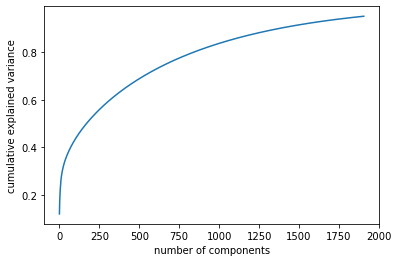

In [23]:
plt.plot(np.cumsum(ratios))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


In [24]:
# apply pca to reduce feature dimenstions
train_pca = pca.transform(train_scaled)

In [25]:
# after dimention reduction
train_pca.shape, user_train1.shape

((22205, 1906), (22205, 4880))

In [26]:
# fit knn model with pearson correlation similarity
nbr_corr_pca = NearestNeighbors(metric='correlation',n_neighbors=5)
nbr_corr_pca.fit(train_pca)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='correlation',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [27]:
'''
arr_train: 1 D arrary and so need to be reshaped as a 2-D array 
n: n_neighbors
k: top k movies 
output: a dictionary with user_id as key and recommended movies list for each user
'''

def get_recomm_kmovies_corr(arr_train,df_train, model,n,topk):
    recomm_dict={}
    df_train_copy=df_train.copy()
    df_train_copy.reset_index(inplace=True)
# loop each index and get their neighbors
    for i in range(df_train.shape[0]):
# Turn find the user_id for each index in the model output
# (n+1) here means n neighobors because the return from the indices includes user self which correlation is one
        distances, indices = model.kneighbors(arr_train[i].reshape(1, -1), n_neighbors = n+1)
        indices_list = indices[0].tolist()
        uid=df_train_copy.iloc[i, :]['userId']
#         indices_list.remove(i) # remove user self
        l=[]
        for k in indices_list:
            neirbor_uid=df_train_copy.iloc[k, :]['userId'].astype(int) #map neibor index to userid
            m=train_seen_df.loc[train_seen_df.userId==neirbor_uid,'movieIds'].values[0] # get movids for each neibor userid
            l.append(m) # Get all movies     
        unnested= [k for i in l for k in i] #unnest the list
        if topk > len(unnested):
            mvote = topKFrequent(unnested, topk)
        else:
            mvote = list(set(unnested))  
        recomm_dict[uid]=mvote
    return recomm_dict

#### get recommendations for each user

In [28]:
%%time
corr_recomm_dict=get_recomm_kmovies_corr(train_pca,user_train1, nbr_corr_pca, 5, 50)

CPU times: user 1h 31min 15s, sys: 35min 13s, total: 2h 6min 28s
Wall time: 2h 6min 38s


In [29]:
# get evaluation score
test_seen_df['corr_user_recomm']=test_seen_df['userId'].map(corr_recomm_dict)
# test_seen_df.head(2)
test_seen_df['corr_user_eval']=test_seen_df.apply(lambda row: evaluation(row.movieId, row.corr_user_recomm), axis=1)
test_seen_df.corr_user_eval.mean()

0.26844105271325924

In [32]:
nb = [5,10,20]
topk = [50, 75]
corr_list=[]
for i in nb:
    for k in topk:
        corr_recomm_dict=get_recomm_kmovies_corr(train_pca,user_train1, nbr_corr_pca, i, k)
        test_seen_df['corr_user_recomm']=test_seen_df['userId'].map(corr_recomm_dict)
        test_seen_df['corr_eval']=test_seen_df.apply(lambda row: evaluation(row.movieId, row.corr_user_recomm), axis=1)
        score = test_seen_df.corr_eval.mean()
        l = [i, k, score]
        corr_list.append(l)

In [33]:
corr_list

[[5, 50, 0.26844105271325924],
 [5, 75, 0.26844105271325924],
 [10, 50, 0.34513784195390546],
 [10, 75, 0.34513784195390546],
 [20, 50, 0.4192782332984198],
 [20, 75, 0.4192782332984198]]

### LightFM

In [34]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

In [36]:
item_dict = {}
dft = df_movies[['movieId','title']].sort_values('movieId').reset_index()

for i in range(dft.shape[0]):
    item_dict[(dft.loc[i, 'movieId'])] = dft.loc[i, 'title']

In [37]:
# create rating dictionary: key as movieId, value as average ratings
# dfr= df_ratings.groupby('movieId').agg({'rating':'mean'}).reset_index().rename({'rating':"avg_rating"})
dfr = df_ratings.groupby('movieId').agg({'rating':'mean'}).reset_index()
dfr.set_index('movieId')['rating'].to_dict()
rating_dict = dict(zip(dfr.movieId, dfr.rating))

In [38]:
# add avg ratings to the movies dataframe
df_movies['avg_rating'] = df_movies['movieId'].map(rating_dict)
df_movies['avg_rating'] = round(df_movies['avg_rating'],1)
print(df_movies.head(3))

# dummify categorical features
dfr_transformed = pd.get_dummies(df_movies[['movieId','avg_rating']], columns = ['avg_rating'])
print(dfr_transformed.shape)
# dfr_transformed.drop(columns =['title','year','title2'], inplace= True)
# print(dfr_transformed.shape)

print(dfr_transformed.head(2))

   movieId                    title    year            title2  \
0        1         Toy Story (1995)  1995.0         Toy Story   
1        2           Jumanji (1995)  1995.0           Jumanji   
2        3  Grumpier Old Men (1995)  1995.0  Grumpier Old Men   

   (no genres listed)  Action  Adventure  Animation  Children  Comedy  Crime  \
0               False   False       True       True      True    True  False   
1               False   False       True      False      True   False  False   
2               False   False      False      False     False    True  False   

   Documentary  Drama  Fantasy  Film-Noir  Horror   IMAX  Musical  Mystery  \
0        False  False     True      False   False  False    False    False   
1        False  False     True      False   False  False    False    False   
2        False  False    False      False   False  False    False    False   

   Romance  Sci-Fi  Thriller    War  Western  avg_rating  
0    False   False     False  False    False  

In [39]:
# convert to csr matrix
movies_csr = csr_matrix(dfr_transformed.drop('movieId', axis=1).values)
movies_csr

<27278x44 sparse matrix of type '<class 'numpy.uint8'>'
	with 26744 stored elements in Compressed Sparse Row format>

In [40]:
user_id = list(user_train1.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1

In [41]:
# top k Recommendation
def recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 50, show = True):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items), item_features=movies_csr))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
#     known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
#     scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    return return_score_list

In [42]:
# convert to csr matrix
user_train1_csr = csr_matrix(user_train1.values)
user_train1_csr

<22205x4880 sparse matrix of type '<class 'numpy.float32'>'
	with 3139784 stored elements in Compressed Sparse Row format>

In [52]:
%%time
learning_rate = 0.1
alpha = 1e-05 
epochs = 100 
num_components = 32

warp_model = LightFM(loss='warp',learning_rate = learning_rate,no_components=num_components,user_alpha=alpha,item_alpha=alpha)
#                     learning_schedule='adagrad', max_sampled=100
                                      
bpr_model = LightFM(loss='bpr',learning_rate = learning_rate ,no_components=num_components,user_alpha=alpha,item_alpha=alpha)
#                     learning_schedule='adagrad',
                                       
warp_model.fit(user_train1_csr, epochs = epochs, num_threads = 16, verbose = False)
bpr_model.fit(user_train1_csr, epochs = epochs, num_threads = 16, verbose = False)

CPU times: user 13min 33s, sys: 1.62 s, total: 13min 35s
Wall time: 13min 36s


In [53]:
%%time
warp_dict={}
for key, value in user_dict.items():
    warp_dict[key] = recommendation_user(warp_model, user_train1, key, user_dict, item_dict)

bpr_dict={}
for key, value in user_dict.items():
    bpr_dict[key] = recommendation_user(bpr_model, user_train1, key, user_dict, item_dict)

CPU times: user 5min 41s, sys: 960 ms, total: 5min 42s
Wall time: 5min 43s


In [54]:
test_seen_df['bpr_user_recomm']=test_seen_df['userId'].map(bpr_dict)
test_seen_df['bpr_user_eval']=test_seen_df.apply(lambda row: evaluation(row.movieId, row.bpr_user_recomm), axis=1)
test_seen_df.bpr_user_eval.mean()

0.012845628661107215

In [55]:
%%time
test_seen_df['warp_user_recomm']=test_seen_df['userId'].map(warp_dict)
test_seen_df['warp_user_eval']=test_seen_df.apply(lambda row: evaluation(row.movieId, row.warp_user_recomm), axis=1)
test_seen_df.warp_user_eval.mean()

CPU times: user 128 ms, sys: 4.31 ms, total: 133 ms
Wall time: 133 ms


0.013116894474609982

In [68]:
%%time
learning_rate = 10000
alpha = 1e-05 
epochs = 20
num_components = 20

warp_model = LightFM(loss='warp',learning_rate = learning_rate,no_components=num_components,user_alpha=alpha,item_alpha=alpha)
#                     learning_schedule='adagrad', max_sampled=100
                                      
bpr_model = LightFM(loss='bpr',learning_rate = learning_rate ,no_components=num_components,user_alpha=alpha,item_alpha=alpha)
#                     learning_schedule='adagrad',
                                       
warp_model.fit(user_train1_csr, epochs = epochs, num_threads = 16, verbose = False)
bpr_model.fit(user_train1_csr, epochs = epochs, num_threads = 16, verbose = False)

CPU times: user 10min 36s, sys: 1.33 s, total: 10min 38s
Wall time: 10min 39s


In [69]:
%%time
warp_dict={}
for key, value in user_dict.items():
    warp_dict[key] = recommendation_user(warp_model, user_train1, key, user_dict, item_dict)

bpr_dict={}
for key, value in user_dict.items():
    bpr_dict[key] = recommendation_user(bpr_model, user_train1, key, user_dict, item_dict)

CPU times: user 6min 24s, sys: 3.24 s, total: 6min 27s
Wall time: 6min 28s


In [70]:
test_seen_df['bpr_user_recomm']=test_seen_df['userId'].map(bpr_dict)
test_seen_df['bpr_user_eval']=test_seen_df.apply(lambda row: evaluation(row.movieId, row.bpr_user_recomm), axis=1)
test_seen_df.bpr_user_eval.mean()

0.009259984052240253

In [71]:
%%time
test_seen_df['warp_user_recomm']=test_seen_df['userId'].map(warp_dict)
test_seen_df['warp_user_eval']=test_seen_df.apply(lambda row: evaluation(row.movieId, row.warp_user_recomm), axis=1)
test_seen_df.warp_user_eval.mean()

CPU times: user 1.21 s, sys: 10.1 ms, total: 1.22 s
Wall time: 1.21 s


0.020979628707173813

In [ ]:
%%time
learning_rate = 10000
alpha = 1e-05 
epochs = 20
num_components = 20

warp_model = LightFM(loss='warp',learning_rate = learning_rate,no_components=num_components,user_alpha=alpha,item_alpha=alpha)                                       
warp_model.fit(user_train1_csr, epochs = epochs, num_threads = 16, verbose = False)

warp_dict={}
for key, value in user_dict.items():
    warp_dict[key] = recommendation_user(warp_model, user_train1, key, user_dict, item_dict)
    
test_seen_df['warp_user_recomm']=test_seen_df['userId'].map(warp_dict)
test_seen_df['warp_user_eval']=test_seen_df.apply(lambda row: evaluation(row.movieId, row.warp_user_recomm), axis=1)
test_seen_df.warp_user_eval.mean()

In [80]:
%%time
learning_rate = 1000000
alpha = 1e-05 
epochs = 20
num_components = 20

lightfm = LightFM(learning_rate = learning_rate,no_components=num_components,user_alpha=alpha,item_alpha=alpha)
#                     learning_schedule='adagrad', max_sampled=100
                                       
lightfm.fit(user_train1_csr, epochs = epochs, num_threads = 16, verbose = False)


CPU times: user 1h 40min 42s, sys: 4.63 s, total: 1h 40min 47s
Wall time: 1h 40min 51s


In [81]:
%%time
lightfm_dict={}
for key, value in user_dict.items():
    lightfm_dict[key] = recommendation_user(lightfm, user_train1, key, user_dict, item_dict)

CPU times: user 2min 48s, sys: 449 ms, total: 2min 49s
Wall time: 2min 49s


In [82]:
test_seen_df['lightfm_user_recomm']=test_seen_df['userId'].map(lightfm_dict)
test_seen_df['lightfm__user_eval']=test_seen_df.apply(lambda row: evaluation(row.movieId, row.lightfm_user_recomm), axis=1)
test_seen_df.lightfm__user_eval.mean()

0.01654046243766223

In [ ]:
%%time
learning_rate = 1000000
alpha = 1e-05 
epochs = 20
num_components = 200

lightfm = LightFM(learning_rate = learning_rate,no_components=num_components,user_alpha=alpha,item_alpha=alpha)
#                     learning_schedule='adagrad', max_sampled=100
                                       
lightfm.fit(user_train1_csr, epochs = epochs, num_threads = 16, verbose = False)
lightfm_dict={}
for key, value in user_dict.items():
    lightfm_dict[key] = recommendation_user(lightfm, user_train1, key, user_dict, item_dict)
test_seen_df['lightfm_user_recomm']=test_seen_df['userId'].map(lightfm_dict)
test_seen_df['lightfm__user_eval']=test_seen_df.apply(lambda row: evaluation(row.movieId, row.lightfm_user_recomm), axis=1)
test_seen_df.lightfm__user_eval.mean()

In [85]:
%%time
learning_rate = 100000000
alpha = 1e-05 
epochs = 20
num_components = 20

lightfm = LightFM(learning_rate = learning_rate,no_components=num_components,user_alpha=alpha,item_alpha=alpha)
#                     learning_schedule='adagrad', max_sampled=100
                                       
lightfm.fit(user_train1_csr, epochs = epochs, num_threads = 16, verbose = False)

lightfm_dict={}
for key, value in user_dict.items():
    lightfm_dict[key] = recommendation_user(lightfm, user_train1, key, user_dict, item_dict)
    
test_seen_df['lightfm_user_recomm']=test_seen_df['userId'].map(lightfm_dict)
test_seen_df['lightfm__user_eval']=test_seen_df.apply(lambda row: evaluation(row.movieId, row.lightfm_user_recomm), axis=1)
test_seen_df.lightfm__user_eval.mean()

CPU times: user 3h 25min 3s, sys: 10.6 s, total: 3h 25min 14s
Wall time: 3h 25min 24s


0.008142481021022824

In [83]:
%%time
learning_rate = [100,100000]
num_components = [20,50]
alpha = 1e-05
epochs = [10,50]
bpr_list =[]
for i in learning_rate:
    for k in num_components:
        bpr_model = LightFM(loss='bpr',learning_rate = i,no_components=k ,user_alpha=alpha,item_alpha=alpha)
        bpr_model.fit(user_train1_csr, epochs = epochs, num_threads = 16, verbose = False)
        bpr_dict={}
        for key, value in user_dict.items():
            bpr_dict[key] = recommendation_user(bpr_model, user_train1, key, user_dict, item_dict)
            test_seen_df['bpr_user_recomm']=test_seen_df['userId'].map(bpr_dict)
            test_seen_df['bpr_user_eval']=test_seen_df.apply(lambda row: evaluation(row.movieId, row.bpr_user_recomm), axis=1)
            score = test_seen_df.bpr_user_eval.mean()
            l = [i, k, alpha, epochs, score]
            bpr_list.append(l)
                    
            


TypeError: 'list' object cannot be interpreted as an integer

In [67]:
df_bpr = pd.DataFrame(bpr_list,columns=['learning_rate','num_components','alpha','epochs','evaluation_score'])

In [84]:
learning_rate = [100,100000]
num_components = [20,50]
alpha = 1e-05
epochs = [10,50]
warp_list =[]
for i in learning_rate:
    for k in num_components:
        warp_model = LightFM(loss='warp',learning_rate = i,no_components=k,user_alpha=alpha,item_alpha=alpha)
        warp_model.fit(user_train1_csr, epochs = epochs, num_threads = 16, verbose = False)
        warp_dict={}
        for key, value in user_dict.items():
            warp_dict[key] = recommendation_user(warp_model, user_train1, key, user_dict, item_dict)
            test_seen_df['warp_user_recomm']=test_seen_df['userId'].map(warp_dict)
            test_seen_df['warp_user_eval']=test_seen_df.apply(lambda row: evaluation(row.movieId, row.warp_user_recomm), axis=1)
            score = test_seen_df.warp_user_eval.mean()
            l = [i, k, alpha, epochs, score]
            warp_list.append(l)

TypeError: 'list' object cannot be interpreted as an integer

In [ ]:
df_warp = pd.DataFrame(warp_list,columns=['learning_rate','num_components','alpha','epochs','evaluation_score'])

## Hyperparameter tuning

https://stackoverflow.com/questions/34624978/is-there-easy-way-to-grid-search-without-cross-validation-in-python

In [ ]:
def test_regression():
    # Check regression for various parameter settings.
    rng = check_random_state(0)
    X_train, X_test, y_train, y_test = train_test_split(boston.data[:50],
                                                        boston.target[:50],
                                                        random_state=rng)
    grid = ParameterGrid({"max_samples": [0.5, 1.0],
                          "max_features": [0.5, 1.0],
                          "bootstrap": [True, False],
                          "bootstrap_features": [True, False]})

    for base_estimator in [None,
                           DummyRegressor(),
                           DecisionTreeRegressor(),
                           KNeighborsRegressor(),
                           SVR()]:
        for params in grid:
            BaggingRegressor(base_estimator=base_estimator,
                             random_state=rng,
                             **params).fit(X_train, y_train).predict(X_test)

In [ ]:
# Create params grid object

from sklearn.model_selection import ParameterGrid

param_grid = {
              'model' : [m]
              , 'initial' : ['730 days','500 days']
              , 'period'  : ['180 days']
              , 'horizon' : ['365 days']
              }

>>> list(ParameterGrid(param_grid))
    [{'model': <fbprophet.forecaster.Prophet at 0x11cd0bba8>,
      'initial': '730 days',
      'period': '180 days',
      'horizon': '365 days'},
     {'model': <fbprophet.forecaster.Prophet at 0x11cd0bba8>,
      'initial': '500 days',
      'period': '180 days',
      'horizon': '365 days'}]
   